# II. How to: FitDarkCurrentProcess
# From the raw data to Fit the Dark current

# Introduction

This is an example of how to fit the dark current.

The distribution of pixels values in a CCD comes from the convolution of the pixel charge with the pixel readout noise. The pixel charge is the sum of a Poisson-distributed leakage current accumulated during the exposure and a ionized signal charge (from a ionizing particle that interacts with the silicon target). The readout noise is paramtrized from the pixel value distribution of blanks and overscans, and found to be well-described by the convolution of a Poisson with average $\lambda$ and a Gaussian of standard deviation $\sigma$.

If the input image contains tracks, the best is to estimate the dark current only using the first two single electron peaks where contribution from any ionizing particle is almost negligigle. In this case the pixel value distribution (in units of ADU) for the n-first single electron peaks is derived as

\begin{equation}
    \mathcal{N} \cdot \sum_{n=0}^{n-th} \mathcal{P}(n- \frac{\mu_{0}}{k} | \lambda) \circledast \mathcal{G}(n-\frac{\mu_{0}}{k},\sigma) \qquad\qquad\qquad\qquad [1]
\end{equation}

where

* $n$ corresponds to the number of electrons of the corresponding single electron peak
* $k$ is the relative calibration constant (or gain) in units of ADU/e$^{-}$
* $\lambda$ is the Poisson parameter in units of $e^{-}/$pix
* $\mu_{0}$ corresonds to the center of the zero-charge single electron peak (in units of ADU); if pedestal have been done, should be around 0 ADU.
* $\sigma$ is the single electron resolution, the noise, i.e. the standard deviation of the gaussian to be the same for all fitted peaks (in units of ADU/pix).

This is done by `FitDarkCurrentProcess` provided by `pysimdamicm.processes.skiper_analysis` which contains a large number of [processes](https://ncastell.web.cern.ch/ncastell/pysimdamicm/howtouse_analysis.html#process-by-process)  related to skipper images.


This process use [ROOT.TH1F.Fit](https://root.cern.ch/root/htmldoc/guides/users-guide/FittingHistograms.html) to fit the pixel charge distribution to equation 1.



# How to

## Using the Python Interpreter

### 1. Load `pysimdamicm` and some other useful packages

In [1]:
%matplotlib inline

# loading damicm module
import pysimdamicm as ccd

# loading other packages
import numpy as np
from matplotlib import pyplot as plt
import ROOT

Welcome to JupyROOT 6.14/06


###  2. Define where your data is 

In [2]:
# variable pointing where my#### data is
path_to_raw_data = "/data/workdir/compton/data/calidaq_backup/DataTaking/Am241/skip_2000_img/"

# pattern file name
img_pattern_file_name = "Image_Am241_Source_55_{}.fits"
# absolute path to the file name
file_name = "{}/{}".format(path_to_raw_data,img_pattern_file_name)

print("\nMy images follows the patter file name:\n {}\n".format(file_name.format("*")))


My images follows the patter file name:
 /data/workdir/compton/data/calidaq_backup/DataTaking/Am241/skip_2000_img//Image_Am241_Source_55_*.fits



### $\color{red}{\text{3. Config}}$
### This is the class to read a JSON configuration file

#### In data is used to interpret correctly the input fits file, and in simulations to properly define all process to be simulated. 
##### See also [I_howto](I_howto_RawData.ipynb)

For this example I will use the default configuration file `panaSKImg_configuration.json` that can be found at `pysimdamicm.json`.

To load this configuration file you can use the class `Config` provided by `pysimdamicm.utils.config`. This class reads and interpret JSON files to configure simulations and data. 

Create a configuration object to correctly interpret our images:

In [3]:
# path where our JSON file is
cfg_file = "{}/json/panaSKImg_configuration.json".format(ccd.__path__[0])

# False to interpret the JSON file as a configuration for data instead of simulations (default one) 
cfg = ccd.utils.config.Config(cfg_file, simulations=False)

In [4]:
print(" 'cfg' contains a dictionary {} with two main sections: ".format(type(cfg.configuration)))
for k in cfg.configuration.keys(): print("\t * ", k)
    
print("\n Where each section contains a set of sections: ")
_ =  [[print("\t {}: {}".format(k,sk)) for sk in cfg.configuration[k]] for k in sorted(cfg.configuration.keys())]

 'cfg' contains a dictionary <class 'dict'> with two main sections: 
	 *  process
	 *  input

 Where each section contains a set of sections: 
	 input: image
	 input: scp
	 input: convention
	 process: RNvsNskipsPlot
	 process: ClusterFinder
	 process: MaskImageProcess
	 process: CompressSkipperProcess
	 process: ChargeLossPlot
	 process: FitCalibrationConstant
	 process: PedestalSubtractionProcess
	 process: SignalPatternRecognition
	 process: FFTNoisePlot
	 process: sequence
	 process: FitDarkCurrentProcess


For now we will just focus on seciton **input** that corresponds to our input data, i.e. our image. Relevant for this exercise are the sections:

* conventions: to inform the name of some keywords that should be found in the header of the input file
* image: to inform about overscan and prescan regions, skip range, coorections to apply data before execute any process ... 

In [5]:
print(ccd.utils.config.json.dumps(cfg.configuration['input'], indent=4, sort_keys=True))

{
    "convention": {
        "Ncols": "NAXIS1",
        "Npbin": "NPBIN",
        "Nrows": "NAXIS2",
        "Nsbin": "NSBIN",
        "Nskips": "NDCMS",
        "ampl": "AMPL",
        "exposure_time": "MEXP",
        "read_time": "MREAD"
    },
    "image": {
        "active_region_cols": null,
        "active_region_rows": null,
        "axis_to_compress": 1,
        "correct_leach_bug": true,
        "correct_polarity": false,
        "extensions": 0,
        "id_col_end": -1,
        "id_col_start": 0,
        "id_row_end": -1,
        "id_row_start": 0,
        "id_skip_end": -1,
        "id_skip_start": 3,
        "n_cols_overscan": 15,
        "n_cols_prescan": 2,
        "n_rows_overscan": 0,
        "n_rows_prescan": 0,
        "skip_image": true
    },
    "scp": {}
}


From the **image** section:
* the image should be corrected by the 'leach_bug' but not from 'polarity'
* axis to compress corresponds the direccion of the serial register, in this case: cols (1)
* overscan col region: 15 last columns
* prescan col region: 2 first columns
* no overscan and prescan on rows
* the rest of the image, will be interpreted as the sensor or active region
* skip region: starting with mesaure 3 up to the last (negative value implies last dimension, -1)


#### For this example i will use an image that has 2000 single skip measurements



In [6]:
print("Using image \n", file_name.format('skip_1'))

Using image 
 /data/workdir/compton/data/calidaq_backup/DataTaking/Am241/skip_2000_img//Image_Am241_Source_55_skip_1.fits


### $\color{red}{\text{4. BuilderRawData}}$
### This is the class to read an image file
##### See also [I_howto](I_howto_RawData.ipynb)

The class `BuilderRawData` provided by `pysimdamicm.io.rawdata` is used to create an object with our data from the input file (in this example, as a fits file object).

This class can use the default configuration to interpret our data or read from a configuration object. 

For this example, we will use the second option and use the already created `cfg` configuration object to correctly interpret our data. These are the parameters needed to interpret our image:

In [7]:
rdata = ccd.io.rawdata.BuilderRawData(file_name.format('skip_1'), cfg.configuration['input'])

Print INFO.
General info of the fits file
****************************************************************************
Filename: /data/workdir/compton/data/calidaq_backup/DataTaking/Am241/skip_2000_img//Image_Am241_Source_55_skip_1.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      84   (550000, 60)   int16 (rescales to uint16)   
None
Displaying full header ext= 0
****************************************************************************
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =               550000 / length of data axis 1                          
NAXIS2  =                   60 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible

#### An extra step is needed to read all regions of an image: overscan, prescan and sensor regions

Internally what this function does is the creation of a boolean array for each region. This boolean array with the same size than the full image, should be used against the object `rdata.image_mean_compressed` to select only regions we are insterested in by using `numpy.ma.array`. The object `rdata.image_mean_compressed` is the averaged skip image (see next steps).

In [8]:
rdata.prepare_data()

RawData INFO.
 *********************************************************************** 
 ********* Define mask for sensor and over/pre-scan regions 'Image_Am241_Source_55_skip_1.fits' ********* 
 *********************************************************************** 

 * Active region: 
		rows=0:60
		cols=2:260

 * Overscan  in cols: 
		rows=0:60
		cols=260:275

 * Prescan  in cols: 
		rows=0:60
		cols=0:2

 * NO Overscan  in rows

 * NO Prescan in rows
 ***********************************************************************. 



#### Our data image 

The attribute `image` of `rdata` contains our data image. It is an array of 3 dimensions if the input file corresponds to an skipper image, and a 2D is is the already averaged image.

The dimensions are for:
* number of rows
* number of cols
* number of skips

In [9]:
rdata.image.shape

(60, 275, 2000)

This image has 60 rows, 275 columns and each pixels has been measured 2000 times.

### $\color{red}{\text{5. CompressSkipperProcess}}$
### This is the process to create the averaged skipper image

To compress the image we will use the class `CompressSkipperProcess` provided by `pysimdamicm.process.skiper_analysis`.

In [10]:
comp = ccd.processes.skipper_analysis.CompressSkipperProcess()

### How can we configure this process?

The user can change the following configuration parameters:

In [11]:
comp.info()

<CompressSkipsProcess> with sequence id 10.
 List of public data members: 
	 * __sequence_id__ = 10 
	 * __verbose__ = False 
	 * func_to_compress = ['mean', 'std'] 
	 * id_col_end = nan 
	 * id_col_start = nan 
	 * id_row_end = nan 
	 * id_row_start = nan 
	 * id_skip_end = nan 
	 * id_skip_start = nan 
	 * image = raw 
	 * save_image = False 
	 * save_plots = False 


* The parameters `id_XXX_start` and `id_XXX_col` can be used to limit a region of the image where the process will be executed. The user can limit the columns, rows or skips. These parameters are from the abstract classs `abps`, any process will have them, but not always have sense to delimit. Be careful on using it! If no region is defined, the one by default will be selected. If these parameters have been defined through the configuration JSON filethis parameters on the JSON file when loading data, these will be used.

* `func_to_compress` is a list of statistical functions (that must exist on `numpy`) to create the image. A compressed image for each function will be created and added as a new attribute on the `RawData` with the name: `image_FUNC_compressed` where `FUNC` is the used function name. 

* `save_img` to save the compressed image as a fits file
* `save_plots` to save the debug plots

Set `__verbose__` to see online the debug plots.


#### Example 1: Compress the image without using the first 10 measurements

In [12]:
comp.id_skip_start = 10
comp.execute_process(rdata)
print("Total pixel charge: ", rdata.image_mean_compressed.sum())

Process <CompressSkipsProcess> INFO. Compressing raw image data using the following statistics: ['mean', 'std']
     - used skip range 10:2000
     - image (60, 275, 1990) have been reduced to 60x275

Total pixel charge:  80913010.51758793


#### Example 2: Compress the image without using the first 2 measurements:

In [13]:
comp.id_skip_start = 2
comp.execute_process(rdata)
print("Total pixel charge: ", rdata.image_mean_compressed.sum())

Process <CompressSkipsProcess> INFO. Compressing raw image data using the following statistics: ['mean', 'std']
     - used skip range 2:2000
     - image (60, 275, 1998) have been reduced to 60x275

Total pixel charge:  80871728.03953955


### $\color{red}{\text{6. PedestalSubtractionProcess}}$
### This is the process to equalize the image

The pedestal is the offset value of our pixel charge. We should expect that pixels without charge to have charge consistent with zero, but that is not the case. The reading measurements has an offset, that should be remove in order to have the single electron peak that corresponds to pixels without charge to be centered at 0.

To subtract the pedestal from image we will use the class `CompressSkipperProcess` provided by `pysimdamicm.process.skiper_analysis`.

In [14]:
ped = ccd.processes.skipper_analysis.PedestalSubtractionProcess()

Let's take a look on the configuration parameters available for this process:

In [15]:
ped.info()

<PedestalSubtractionProcess> with sequence id 20.
 List of public data members: 
	 * __sequence_id__ = 20 
	 * __verbose__ = False 
	 * axis = full 
	 * histequ = False 
	 * id_col_end = nan 
	 * id_col_start = nan 
	 * id_row_end = nan 
	 * id_row_start = nan 
	 * id_skip_end = nan 
	 * id_skip_start = nan 
	 * image = mean_compressed 
	 * in_overscan = True 
	 * method = gauss_fit 
	 * n_sigma_to_mask = -1 
	 * n_sigma_win_fit = 3.0 
	 * save_image = False 
	 * save_plots = False 
	 * show_fit = False 
	 * use_mad = True 


#### Configuration Parameters for Pedestal Subtracted Process:

This process has a lot of parameters and for that a lot of combinations. 
*$\color{orange}{\text{Be careful when using them,  altough some options are allowd, this does not mean that they all make sense!}}$*

#### `image`  config param
The option `image` refers to which image should be applied this procress. It should be one of the image from `rdata`: 

In [16]:
print("Possible attributes: ")
for attr in dir(rdata):
    if str.startswith(attr, 'image'):
        print("\t ", attr)

Possible attributes: 
	  image
	  image_header
	  image_mean_compressed
	  image_std_compressed


The attribute `image_header` is not an image, is the header object from the input fits file. The options are:
In this example we have the 
* the raw data: `image`
* or one of the images created by CompressSkipperProcess:
    * `image_mean_compressed`
    * `image_std_compressed`
    
By default this process points to `image_mean_compressed`.

#### `in_overscan` config param
This is a boolean parameter to select only the overscan cols region to estimate the pedestal, or on the contrary, to use the full image.

The selected region (full image or only overscan cols region) can also be $\color{green}{\text{masked}}$ (see `n_mad_mask`). This prevent to include pixels from ionizing particles (pixels from tracks will overstimate the pedestal). 



#### `n_mad_mask` config param

Pixels from ionizing particles should not be taking into account during pedestal estimation. For that, those pixels with charge above a certain threshold can be masked to prevent it. The process of masking this pixels follows the rule:

those pixels with charge

\begin{equation}
    q_{row,col} > median(q_{row,col}) + n \cdot \text{MAD}
\end{equation}

will not be used to estimate the pedestal. 

`n` is `n_mad_mask`, an integer value (it also accepts floats, if you think it will be better for you case). If negative, no mask at all.

and `MAD` stands for 'median absolute deviation'.


#### `method` config param
Name of the method to be used to estimate the pedestal. There are three implemented methods to estimate the pedestal:
 * `mean`: the pedestal will be estimated as the average of a set of pixels from the image
 * `median`: the pedestal will be estimated as the median of a set of pixels from the image
 * `gauss_fit`: the pedestal will be estimated by fitting a gaussian to a set of pixels, being the pedestal the fitted $\mu$
 
In all the methods, a second parameter is given as an estimator of the dispersion: std, mad and $\sigma$ for the `mean`, `median` and `guass_fit`, respectively. 



The set of pixels to use use depends on the `axis` parameter (see below). 

For method `gauss_fit` the set of pixels also depends on `n_sigma_win_fit` (stands for number of sigmas for the spectral window to be used in the fitting process) and `use_mad` (see later on).

#### `axis` config param
There are the possible options for this parameter:

 * `row`: the pedestal will be estimated and subtracted row by row
 * `col`: the pedestal will be estimated and subtracted col by col
 * `both`: the pedestal will be estimated row by row, subtacted row by row, then an estimation of col by col will be done, to finally subtract that col by col
 * `full`: the full image will be used to estimate a single value for the pedestal
 

####  `n_sigma_win_fit` config param

Method `gauss_fit` fits a gauss to a set of pixels to estimate the pedestal and the disperison (i.e. $\mu$ and $\sigma$ from the fit, respectively). It is extremly important not to include outlier on the fitting process. For that, the algorithm use only those pixel charge within a espectral window:

\begin{equation*}
    q_{row,col} \in [median(q_{row,col}) - n \cdot MAD' , median(q_{row,col}) + n \cdot MAD']
\end{equation*}

where `n` is given by `n_sigma_win_fit`.

The statistic $MAD'$ corresponds to:
* the median absolute deviation, i.e. $MAD$, or
* the MAD as an estimator of the standard deviation, i.e. $1.4826 \cdot MAD$

Being the former less sensitive to outliers (see [wiki](https://en.wikipedia.org/wiki/Median_absolute_deviation) for more detailed information). 

####  `use_mad` config param

This parameter set the use of MAD as an estimator of the standard deviation ($False$) or the MAD itself ($True$).

#### Example 1: Pedestal as the mean of the full image

For sure this is never a good option .... 

In [17]:
%matplotlib inline
# set verbose to True to display intermediate plots
ped.__verbose__ = True

In [18]:
# full image
ped.in_overscan = False
ped.axis = "full"
ped.n_sigma_to_mask = -1
# set method
ped.method = 'mean'
# check all set are done
ped.info()

<PedestalSubtractionProcess> with sequence id 20.
 List of public data members: 
	 * __sequence_id__ = 20 
	 * __verbose__ = True 
	 * axis = full 
	 * histequ = False 
	 * id_col_end = nan 
	 * id_col_start = nan 
	 * id_row_end = nan 
	 * id_row_start = nan 
	 * id_skip_end = nan 
	 * id_skip_start = nan 
	 * image = mean_compressed 
	 * in_overscan = False 
	 * method = mean 
	 * n_sigma_to_mask = -1 
	 * n_sigma_win_fit = 3.0 
	 * save_image = False 
	 * save_plots = False 
	 * show_fit = False 
	 * use_mad = True 


Process <PedestalSubtractionProcess> INFO. Equalize the image by substracting the pedestal.
   - using the full image
   - pedestal as the mean of a [masked] image (axis full)
   - pedestal estimation is 4901.316850881185 and its sigma 3800.21224627658 (in ADUs)
  Pedestral subtracted image recorded as data member image_mean_compressed_pedestal_subtracted of rawdata 




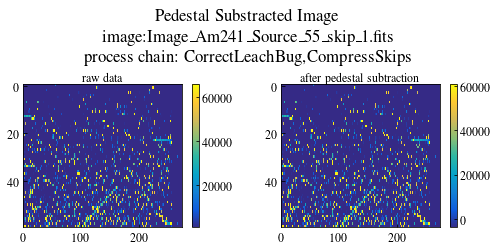

In [19]:
# execute process on raw data
#
ped.execute_process(rdata)

This process create an new attribute on `rdata` object: `image_mean_compressed_pedestal_subtracted`

In [20]:
__process_chain__ = "/CorrectLeachBugProcess/CompressSkipsProcess"

In [21]:
### keeping the image as independent ndarray, to be used later one
image_ps_ex1 = rdata.image_mean_compressed_pedestal_subtracted.copy()

print(" Mean pisel charge before pedestal subtraction: ", rdata.image_mean_compressed.mean())
print(" Mean pixel charge after pedestal subtraction: ", rdata.image_mean_compressed_pedestal_subtracted.mean())
print(" Mean difference: ", rdata.image_mean_compressed.mean()-rdata.image_mean_compressed_pedestal_subtracted.mean())

 Mean pisel charge before pedestal subtraction:  4901.316850881185
 Mean pixel charge after pedestal subtraction:  -6.843809828613744e-13
 Mean difference:  4901.316850881186


The pedestal is just the mean of the full image, see this output and the previous one. 

This methodology to estimate the pedestal (for our type of images) is far from being accurate, but it's allowed! And probably this is never a good option, so to many requirements would have to meet our image: not presence of clusters on the image, uniform pedestal along rows and columns, no sign of noise patterns, ... 

#### Example 2: Pedestal as the median of the full image

Same as before, the use of the full image is never a good idea ... 

Process <PedestalSubtractionProcess> INFO. Equalize the image by substracting the pedestal.
   - using the full image
   - pedestal as the median of a [masked] image (axis full)
   - pedestal estimation is 1101.3871371371372 and its sigma 0.9191691691692085 (in ADUs)
  Pedestral subtracted image recorded as data member image_mean_compressed_pedestal_subtracted of rawdata 




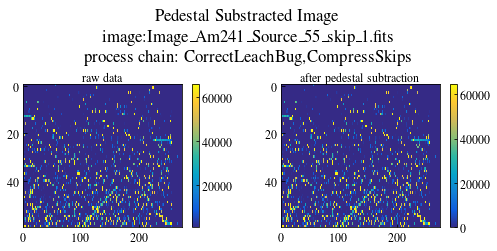

In [22]:
# only for this how to (avoiding overwritting)
rdata.__process_chain__ = __process_chain__

# full image
ped.in_overscan = False
ped.axis = "full"
ped.n_sigma_to_mask = -1
# set method
ped.method = 'median'

ped.execute_process(rdata)

From comparing the output messages from Ex1 and Ex2, we can see that both methods give a very different value for the pedestal!

We run the pedestal subtraction over the same raw data object: $\color{red}{\text{the attribute with the subtracted image has been overwritten!}}$

keeping the subtracted image to be used in the next example:

In [23]:
image_ps_ex2 = rdata.image_mean_compressed_pedestal_subtracted.copy()

#### $\color{red}{\text{Comparing results from Example 1 and Example 2}}$

Where the zero-charge single electrons is located?

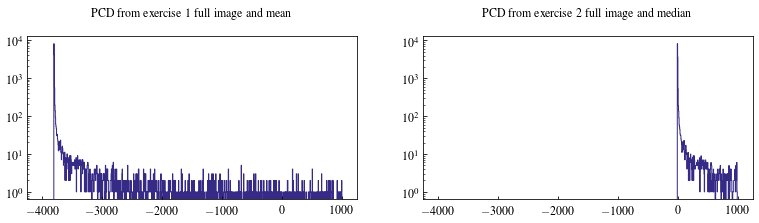

In [24]:
%matplotlib inline
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,3))
## example 1
_ = ax1.hist(image_ps_ex1.flatten(), 1000, range=(-4000,1000), histtype='step')
_ = ax1.title.set_text("PCD from exercise 1 full image and mean")
_ = ax1.set_yscale('log')
## example 2
_ = ax2.hist(image_ps_ex2.flatten(), 1000, range=(-4000,1000), histtype='step')
_ = ax2.title.set_text("PCD from exercise 2 full image and median")
_ = ax2.set_yscale('log')

#### Example 3: Pedestal as the median of the overscan


Process <PedestalSubtractionProcess> INFO. Equalize the image by substracting the pedestal.
   - using overscan region
   - pedestal as the median of a [masked] image (axis full)
   - pedestal estimation is 1100.9847347347347 and its sigma 0.48873873873867524 (in ADUs)
  Pedestral subtracted image recorded as data member image_mean_compressed_pedestal_subtracted of rawdata 




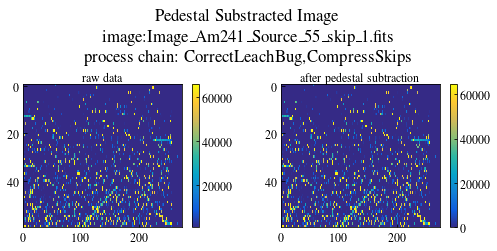

In [25]:
# only for this how to (avoiding overwritting)
rdata.__process_chain__ = __process_chain__

# executing PS process
ped.in_overscan = True
ped.axis = "full"
ped.n_sigma_to_mask = -1
ped.method = 'median'

ped.execute_process(rdata)

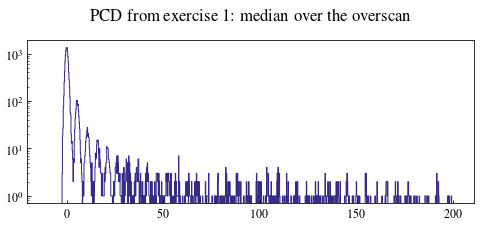

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

_ = ax.hist(rdata.image_mean_compressed_pedestal_subtracted.flatten(), 1000, range=(-10,200), histtype='step')
_ = ax.title.set_text("PCD from exercise 1: median over the overscan")
_ = ax.set_yscale('log')

#### Example 4: Pedestal as the fitted $\mu$ of the overscan row by row


Process <PedestalSubtractionProcess> INFO. Equalize the image by substracting the pedestal.
   - using overscan region
   - masking image: mask all pixels with qij > median + 10 MAD
   - pedestal as the mu of a the fitted gaussian to the zero-charged peak (axis row)
  Pedestral subtracted image recorded as data member image_mean_compressed_pedestal_subtracted of rawdata 




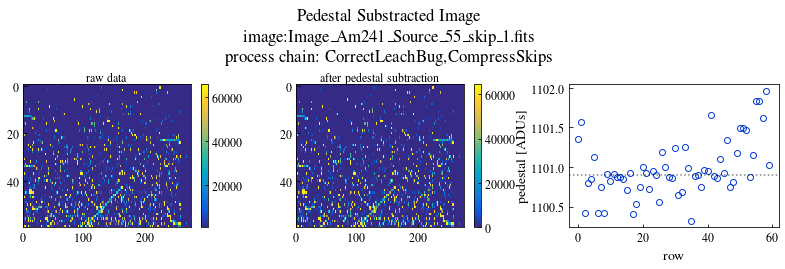

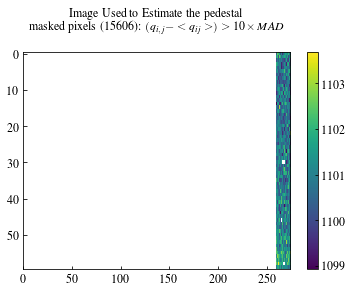

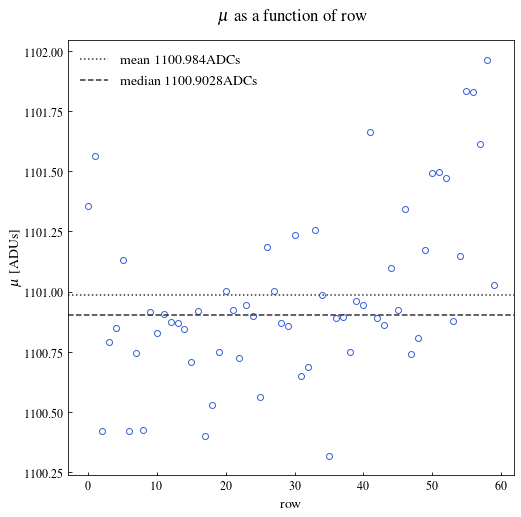

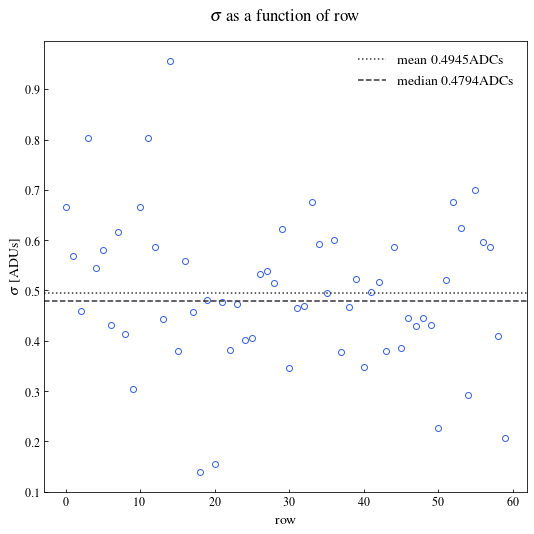

In [27]:
%matplotlib inline
# only for this how to (avoiding overwritting)
rdata.__process_chain__ = __process_chain__

# full image
ped.in_overscan = True
ped.axis = "row"
ped.n_sigma_to_mask = 10
ped.use_mad = True
# set method
ped.method = 'gauss_fit'
ped.execute_process(rdata)

### $\color{red}{\text{7. FitDarkCurrentProcess}}$
### This is the process to fit the dark current 

To fit the dark current we will use the process class `FitDarkCurrentProcess` provided by `pysimdamicm.process.skiper_analysis`.


In [28]:
dcfit = ccd.processes.skipper_analysis.FitDarkCurrentProcess()

### How can we configure this process?

The user can change the following configuration parameters:

In [29]:
dcfit.info()

<FitDarkCurrentProcess> with sequence id 30.
 List of public data members: 
	 * __sequence_id__ = 30 
	 * __verbose__ = False 
	 * binning_size = -1 
	 * calibration = 20 
	 * do_calibration = True 
	 * fit_options = QSE 
	 * id_col_end = nan 
	 * id_col_start = nan 
	 * id_row_end = nan 
	 * id_row_start = nan 
	 * id_skip_end = nan 
	 * id_skip_start = nan 
	 * image = mean_compressed_pedestal_subtracted 
	 * in_overscan = False 
	 * lambda_poisson = 0.05 
	 * method = root 
	 * mu_gauss = 0.0 
	 * n_peaks = 2 
	 * n_sigma_fit = 10 
	 * save_image = False 
	 * save_plots = False 
	 * sigma_gauss = 0.2 


#### Configuration Parameters for Pedestal Subtracted Process:

This process has a lot of parameters and for that a lot of combinations. 
*$\color{orange}{\text{Be careful when using them,  altough some options are allowd, this does not mean that they all make sense!}}$*

#### `image` config param

Same idea as in the previous process (`PedestalSubtractedProcess`). 

The image to be used to fit the dark current can calibrated image (i.e. `image_mean_compressed_pedestal_subtracted_e` pixel charge in units of $e^{-}/$pix, but not introduced yet) or the one from the pedestal subtracted process (i.e. `image_mean_compressed_pedestal_subtracted`, in units of ADU/pix). The later is the one by default.



#### `method` config param

Only one method is availablre right now

#### `in_overscan` config param

Set to use the overscan cols region instead of the active retion (which is the one by default!)

#### `n_peask` config param

Number of single electron peak to fit (from 0, up to `n_peaks` -1 )

####  `n_sigma_fit` config param

To fit the image in units of ADU and without knowing the calibration constant this parameter is quite important. The fitting process is recursive, and the spectral window size change from trail to trail. This number `n_sigma_fit` is used to define the spectral window and using only those pixel charge within the espectral window:

\begin{equation*}
    q_{row,col} \in [-k , (N_{peaks} - 1)*k + n \cdot \sigma_{0}]
\end{equation*}

where 
* `n` is given by `n_sigma_fit` and 
* $k$ is `calibration`
* $N_{peaks}$ is `n_peaks`
* $\sigma_{0}$ is the standard deviation obtained only using the pixels with charge velow 1$e^{-}$ (i.e. $q_{i,j}/k < 1$)

#### `do_calibration` config param

Set this parameter to also fit the calibration constant (or gain). The fit algorithm is assuming the image is in units of ADU and the calibration constant will be also fitted. 

What you can also do also, is use the already calibrated image, and still fit the gain. In this case, the fitted calibration constant should be around 1. This is used to bettter estimate the already know calibration constant which perhaps changed for whatever reason.


#### `calibration` config param

If `do_calibration` is set, just the starting point of the calibration constant.


#### `lambda_poisson`, `mu_gauss` config params

The starting point for the fitting algorithm. If nothing is passed, a first estimation is done internally

#### `binning_size` config param

The binning size for the histogram used to fit the dark current. If negative, the binning size will be integer of $2 \cdot \sqrt{ N_{pixels} }$

#### Example 1: Fitting the Dark Current as well as the gain

Process <FitDarkCurrentProcess> INFO. Fit the n-first peaks to estimate the dark current and the calibration constant.
 Fitting within the spectral range: (-5.3,16.962356198742867)
 Spectral window for Fit:     -5.3 16.962356198742867
   Fit DC Results:
     * Normalization = -6126844.930794448 +/- 1.4142135623730951
     * zero electron peak = 0.0 +/- 1.4938829729963679
     * single electron resolution  = 9.536740132598531e-06 +/- 7.105313665471958
     * dark current = 0.050000000000000044 +/- 6.7406855202100875
     * new gain = 5.299999999999997 +/- 327.9812140049304


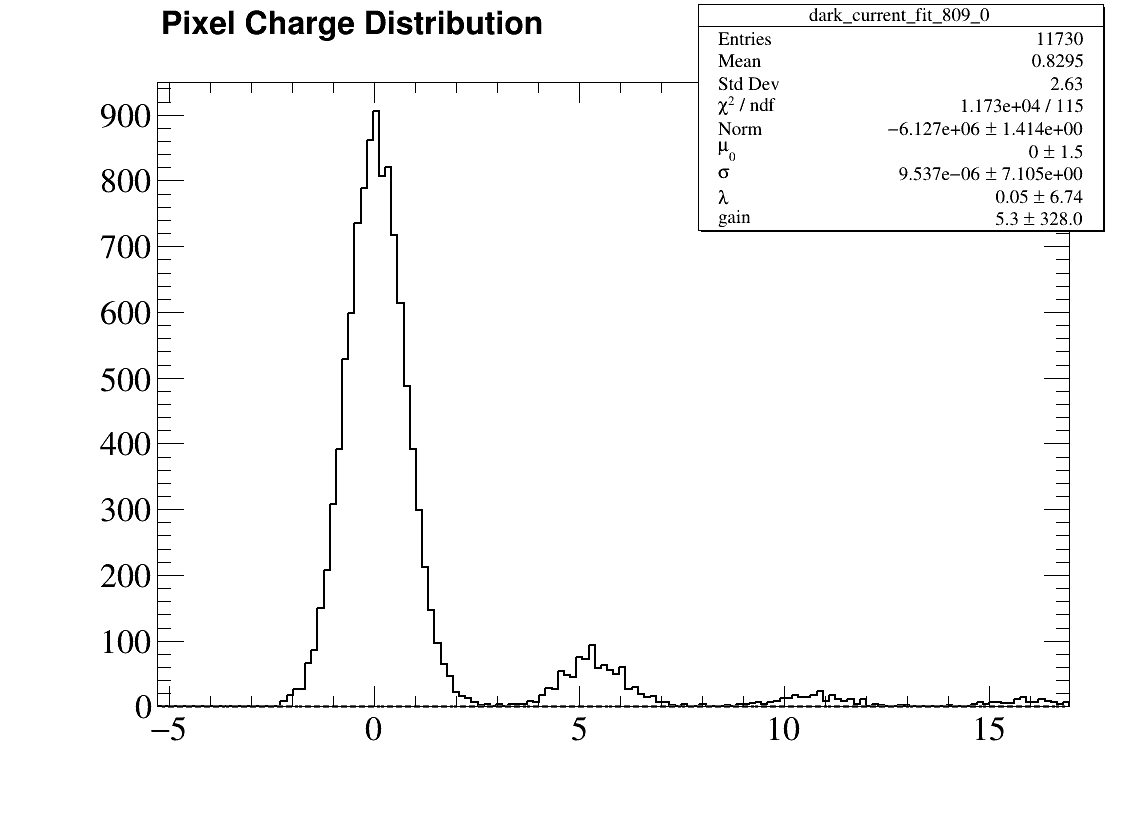

In [35]:
dcfit = ccd.processes.skipper_analysis.FitDarkCurrentProcess()
dcfit.__verbose__ = False
dcfit.do_calibration = True
dcfit.binning_size = 0.15
dcfit.calibration = 5.3
dcfit.n_peaks = 2
dcfit.n_sigma_fit = 10
dcfit.mu_gauss = 0.0
dcfit.sigma_gauss = 0.0
dcfit.fit_options = "QS"

c = ROOT.TCanvas()
c.Draw()
dcfit.execute_process(rdata)
c.Update()